In [26]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns

In [18]:
test_video = 'data/marker_raw_480x480_30fps.mp4'
print(os.path.isfile(test_video))

True


In [19]:
def extract_nth_frame(video_path, n, output_path=None, flip=False):
    cap = cv2.VideoCapture(video_path)
    if n < 1 or n > int(cap.get(cv2.CAP_PROP_FRAME_COUNT)): return None

    for count in range(n-1):
       ret, _ = cap.read()
       if not ret or not cap.isOpened(): break

    ret, frame = cap.read()
    cap.release()
    if not ret: return None

    if flip: frame = cv2.flip(frame, 0)
    if output_path: cv2.imwrite(output_path, frame)
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [20]:
n = 100
test_frame = extract_nth_frame(test_video, n)

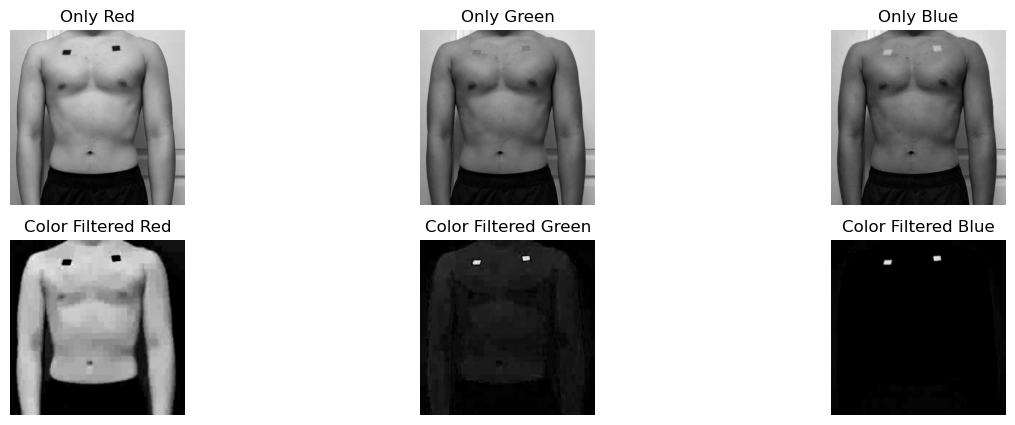

In [21]:
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
for i, a in enumerate(ax[0]):
    a.axis('off')
    a.set_title(f'Only {["Red", "Green", "Blue"][i]}')
    a.imshow(test_frame[:, :, i], cmap='gray')
for i, a in enumerate(ax[1]):
    a.axis('off')
    a.set_title(f'Color Filtered {["Red", "Green", "Blue"][i]}')
    frame = test_frame[:, :, i] - np.min(test_frame, axis=-1)
    a.imshow(frame, cmap='gray')

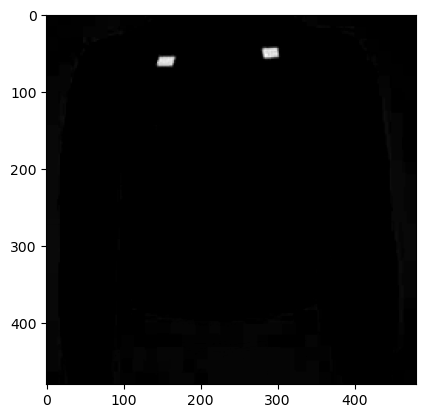

In [22]:
tf_kp = test_frame[:, :, 2] - np.min(test_frame, axis=-1)
plt.figure()
plt.imshow(tf_kp, cmap='gray')
plt.show()

In [23]:
keypoints = cv2.goodFeaturesToTrack(tf_kp, mask=None, 
                                    maxCorners=100,
                                    qualityLevel=0.1,
                                    minDistance=5)
kp1 = np.squeeze(keypoints)
print(f'{len(kp1)} points found')

8 points found


10 points found


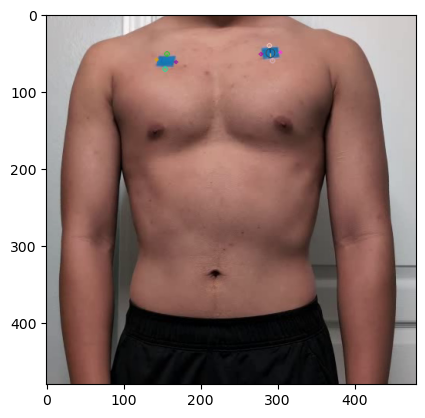

In [24]:
sift = cv2.SIFT_create()
kp_sift = sift.detect(tf_kp, mask=None)
kp2 = np.array([kp.pt for kp in kp_sift])
print(f'{len(kp2)} points found')

sift_out = test_frame.copy()
sift_out = cv2.drawKeypoints(test_frame, kp_sift, sift_out,
                             flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure()
plt.imshow(sift_out)
plt.show()

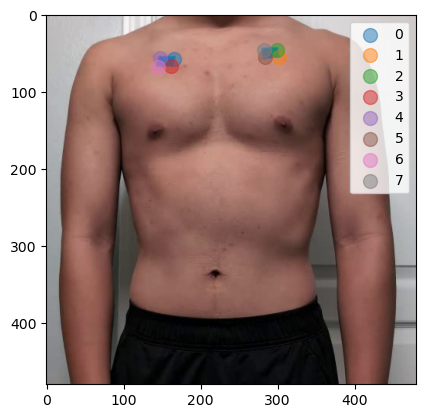

In [25]:
plt.figure()
plt.imshow(test_frame)
for i, (x, y) in enumerate(kp1):
    plt.scatter(x, y, s=100, alpha=0.5, label=str(i))
plt.legend()
plt.show()

In [31]:
# optical flow motion track
def kp_preprocess(frame):
    return frame[:, :, 0] - np.min(frame, axis=-1)
def get_kp(frame):
    keypoints = cv2.goodFeaturesToTrack(frame, mask=None, 
                                        maxCorners=100,
                                        qualityLevel=0.1,
                                        minDistance=5)
    return keypoints
def stabilize_video(video_path):
  # Open the video capture
  cap = cv2.VideoCapture(video_path)

  # Define parameters
  lk_params = dict(
    winSize=(15, 15), 
    maxLevel=2, 
    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

  # Define variables for tracking
  ret, prev_frame = cap.read()
  prev_kp_frame = kp_preprocess(prev_frame)
  prev_pts = get_kp(prev_kp_frame)

  # Lists to store tracked points and motion vectors
  pts = [prev_pts]
  mv = []
  orig_frames = []
  stabilized_frames = []

  while True:
    ret, frame = cap.read()
    if not ret:
      break

    kp_frame = kp_preprocess(frame)

    # Calculate optical flow
    curr_pts, status, err = cv2.calcOpticalFlowPyrLK(
        prev_kp_frame, kp_frame, prev_pts, 
        None, 
        **lk_params)

    # Filter good features
    good_old = prev_pts[status == 1]
    good_new = curr_pts[status == 1]

    # Estimate motion from good features
    if len(good_old) >= 2:
      M, mask = cv2.estimateAffine2D(good_old, good_new)
      mv.append(M)

    # Update for next iteration
    prev_kp_frame = kp_frame.copy()
    prev_pts = good_new.reshape(-1, 1, 2)

    # Stabilize frame (reverse motion)
    h, w = frame.shape[:2]
    avg_mv = np.mean(mv, axis=0)
    inv_M = cv2.invertAffineTransform(avg_mv)
    stabilized_frame = cv2.warpAffine(frame, inv_M, (w, h))

    # Display original and stabilized frame side-by-side
    cv2.imshow('Original Video', frame)
    cv2.imshow('Stabilized Video', stabilized_frame)
    # orig_frames.append(frame)
    # stabilized_frames.append(stabilized_frame)

    # Exit on 'q' press
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Release resources
  cap.release()
  cv2.destroyAllWindows()

  return orig_frames, stabilized_frames


In [28]:
stabilize_video(test_video)